In [14]:
%load_ext kedro.ipython
import pandas as pd
from pycaret.classification import *
from sklearn.metrics import log_loss, f1_score

df_train = pd.read_parquet("../data/processed/base_train.parquet")
df_test = pd.read_parquet("../data/processed/base_test.parquet")

print("Treino:", df_train.info)
print("Teste: ", df_test.info)


The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython
Treino: <bound method DataFrame.info of            lat       lon  minutes_remaining  period  playoffs  shot_distance  \
7006   34.0343 -118.1288                  1       2         0             14   
20760  33.9723 -118.0808                  0       3         0             20   
15143  33.8713 -118.1728                 11       3         0             19   
10506  34.0443 -118.2698                 11       2         0              0   
21377  33.8543 -118.2698                 11       3         0             19   
...        ...       ...                ...     ...       ...            ...   
29740  34.0523 -118.0718                  9       3         1             19   
23272  34.0443 -118.2698                  0       1         0              0   
6023   34.0523 -118.0838                  2       3         0             18   
1104   34.0403 -118.3618                  3       3         0     

In [5]:
import pandas as pd
import mlflow
import mlflow.sklearn  # Substitui mlflow.pycaret
from pycaret.classification import *
from sklearn.metrics import log_loss, f1_score

# 1) Carregar dados
df_train = pd.read_parquet("../data/processed/base_train.parquet")
df_test  = pd.read_parquet("../data/processed/base_test.parquet")

X_test = df_test.drop("shot_made_flag", axis=1)
y_test = df_test["shot_made_flag"]

# 2) Iniciar UM único run no MLflow
with mlflow.start_run(run_name="Treinamento"):
    
    # 2.1) Configurar PyCaret (setup)
    setup(
        data=df_train,
        target="shot_made_flag",
        session_id=42,
        verbose=False,
        html=False
    )
    
    # 2.2) Criar/treinar modelo de Regressão Logística
    lr_model = create_model("lr")
    # 2.3) Criar/treinar modelo de Árvore de Decisão
    dt_model = create_model("dt")
    
    # Obter o pipeline PyCaret para transformar X_test
    pipeline = get_config("pipeline")
    X_test_transformed = pipeline.transform(X_test)

    # -------------------------------------------------------------------------
    #   A) AVALIAÇÃO LOGÍSTICA
    # -------------------------------------------------------------------------
    y_proba_lr = lr_model.predict_proba(X_test_transformed)
    logloss_lr = log_loss(y_test, y_proba_lr)
    print(f"[Logística] log_loss = {logloss_lr:.4f}")

    # Logar métrica no MLflow
    mlflow.log_metric("log_loss_logistica", logloss_lr)
    # Salvar modelo logístico como scikit-learn
    mlflow.sklearn.log_model(lr_model, artifact_path="modelo_logistico")

    # -------------------------------------------------------------------------
    #   B) AVALIAÇÃO ÁRVORE
    # -------------------------------------------------------------------------
    y_proba_dt = dt_model.predict_proba(X_test_transformed)
    y_pred_dt  = dt_model.predict(X_test_transformed)

    logloss_dt = log_loss(y_test, y_proba_dt)
    f1_dt      = f1_score(y_test, y_pred_dt)

    print(f"[Árvore] log_loss = {logloss_dt:.4f}")
    print(f"[Árvore] F1 Score = {f1_dt:.4f}")

    mlflow.log_metric("log_loss_arvore", logloss_dt)
    mlflow.log_metric("f1_score_arvore", f1_dt)

    mlflow.sklearn.log_model(dt_model, artifact_path="modelo_arvore")

    if logloss_lr < logloss_dt:
        print("Regressão Logística obteve melhor log_loss e é a preferida.")
    else:
        print("Árvore obteve melhor log_loss ou F1_score, pode ser a preferida.")


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.5880  0.6183  0.5166  0.5761  0.5447  0.1706  0.1714
1       0.5907  0.6024  0.5092  0.5811  0.5428  0.1752  0.1764
2       0.5854  0.6107  0.4908  0.5770  0.5304  0.1636  0.1653
3       0.5836  0.6029  0.5037  0.5723  0.5358  0.1611  0.1622
4       0.6012  0.6230  0.5111  0.5957  0.5501  0.1958  0.1976
5       0.5607  0.5815  0.4871  0.5443  0.5141  0.1156  0.1162
6       0.5511  0.5791  0.4446  0.5356  0.4859  0.0935  0.0948
7       0.5801  0.6145  0.4659  0.5750  0.5148  0.1518  0.1544
8       0.5810  0.5988  0.4954  0.5711  0.5306  0.1556  0.1569
9       0.5498  0.5685  0.4539  0.5336  0.4905  0.0919  0.0929
Mean    0.5772  0.6000  0.4878  0.5662  0.5240  0.1475  0.1488
Std     0.0165  0.0173  0.0238  0.0198  0.0211  0.0334  0.0336


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.5282  0.5106  0.5756  0.5049  0.5379  0.0601  0.0607
1       0.5255  0.5076  0.5461  0.5025  0.5234  0.0527  0.0528
2       0.5335  0.5056  0.6107  0.5092  0.5554  0.0730  0.0744
3       0.5176  0.5033  0.5554  0.4951  0.5235  0.0383  0.0386
4       0.5290  0.5151  0.5738  0.5057  0.5376  0.0617  0.0622
5       0.5229  0.5113  0.5683  0.5000  0.5320  0.0495  0.0499
6       0.5687  0.5643  0.6144  0.5423  0.5761  0.1405  0.1416
7       0.5352  0.5156  0.5709  0.5124  0.5401  0.0731  0.0735
8       0.5273  0.5118  0.5727  0.5049  0.5367  0.0581  0.0586
9       0.5269  0.5162  0.5572  0.5042  0.5294  0.0561  0.0564
Mean    0.5315  0.5161  0.5745  0.5081  0.5392  0.0663  0.0669
Std     0.0133  0.0166  0.0210  0.0123  0.0151  0.0266  0.0269
[Logística] log_loss = 0.6788


2025/03/31 21:35:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[Árvore] log_loss = 14.4320
[Árvore] F1 Score = 0.5400


2025/03/31 21:36:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regressão Logística obteve melhor log_loss e é a preferida.


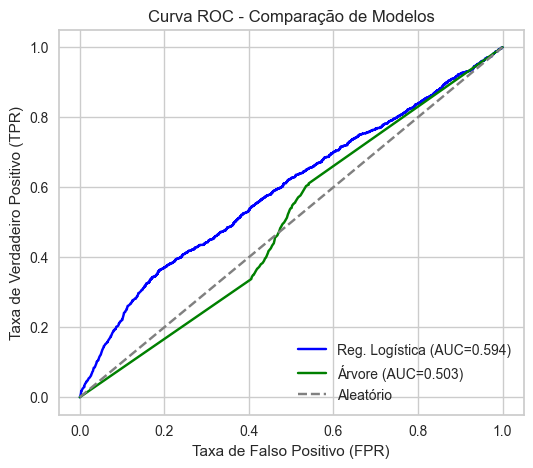

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


lr_probs = y_proba_lr[:, 1]
dt_probs = y_proba_dt[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
auc_lr = roc_auc_score(y_test, lr_probs)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
auc_dt = roc_auc_score(y_test, dt_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"Reg. Logística (AUC={auc_lr:.3f})", color="blue")
plt.plot(fpr_dt, tpr_dt, label=f"Árvore (AUC={auc_dt:.3f})", color="green")
plt.plot([0,1],[0,1],"--", color="gray", label="Aleatório")

plt.title("Curva ROC - Comparação de Modelos")
plt.xlabel("Taxa de Falso Positivo (FPR)")
plt.ylabel("Taxa de Verdadeiro Positivo (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
